In [1]:
import graphlab as gl
import pandas as pd
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models, similarities

# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

product_elec_rating_stats_samsung_sorted_shortlist=gl.load_sframe('./product_elec_rating_stats_samsung_sorted_shortlist')

[INFO] Could not import Theano, will use standard float for default ShardedCorpus dtype.
[INFO] This trial license of GraphLab Create is assigned to revanthg@hotmail.com and will expire on July 10, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-2418 - Server binary: /Users/revanthgarlapati/anaconda/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1434673812.log
[INFO] GraphLab Server Version: 1.4.1


In [2]:
elec_rev_data= gl.load_sframe('./elec_rev_data_new/')
elec_rev_data=elec_rev_data.unpack('X1',column_name_prefix='')

In [3]:
#compute the cumulative months column
product_elec_rating_stats_samsung_sorted_shortlist['cumulativemonths']=12*product_elec_rating_stats_samsung_sorted_shortlist['reviewyear']+product_elec_rating_stats_samsung_sorted_shortlist['reviewmonth']

In [4]:
product_elec_rating_stats_samsung_sorted_shortlist.head()

asin,reviewmonth,reviewyear,Count,Avg of overall,Stdv of overall,Total review count,Total review months
B004CGHDEO,12,2010,1,5.0,0.0,1152,42
B004CGHDEO,1,2011,1,4.0,0.0,1152,42
B004CGHDEO,2,2011,1,3.0,0.0,1152,42
B004CGHDEO,3,2011,1,5.0,0.0,1152,42
B004CGHDEO,6,2011,1,1.0,0.0,1152,42
B004CGHDEO,7,2011,1,5.0,0.0,1152,42
B004CGHDEO,8,2011,3,4.66666666667,0.471404520791,1152,42
B004CGHDEO,9,2011,8,4.875,0.330718913883,1152,42
B004CGHDEO,10,2011,7,4.57142857143,0.728431359085,1152,42
B004CGHDEO,11,2011,6,4.83333333333,0.37267799625,1152,42


In [5]:
##getting a unique list of samsung prodcuts of interest
samsung_product_short_list=list(set(list(product_elec_rating_stats_samsung_sorted_shortlist['asin'])))

In [6]:
cnt=0
extremenegslope=-0.5
extremeposslope=0.5
def my_neg_condition(x):
    return x <extremenegslope
def my_pos_condition(x):
    return x >extremeposslope
neg_count_item=[]
pos_count_item=[]
for itemid,item in enumerate(samsung_product_short_list):
    itemframe = product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] == item]
    rating_list=list(itemframe['Avg of overall'])
    cumulative_month_list=list(itemframe['cumulativemonths'])
    item_slopes=[]
    for i in range(0, len(cumulative_month_list)-1): 
        item_slopes.append((rating_list[i+1]-rating_list[i])/float(cumulative_month_list[i+1]-cumulative_month_list[i]))
       
    neg_count_item.append(sum(map(my_neg_condition, item_slopes))/float(len(item_slopes)))
    pos_count_item.append(sum(map(my_pos_condition, item_slopes))/float(len(item_slopes)))

neg_count_item=[i*100 for i in neg_count_item]
pos_count_item=[i*100 for i in pos_count_item]
print neg_count_item
print 
print pos_count_item

[11.76470588235294, 17.647058823529413, 21.052631578947366, 26.82926829268293, 16.666666666666664, 4.761904761904762, 10.344827586206897, 0.0, 3.8461538461538463, 22.727272727272727, 0.0, 18.421052631578945, 25.0, 13.636363636363635, 3.125, 12.5, 0.0, 14.583333333333334, 13.636363636363635, 13.793103448275861, 5.88235294117647, 3.571428571428571, 21.052631578947366, 0.0, 0.0, 21.73913043478261, 0.0, 0.0, 6.25, 6.451612903225806, 0.0, 23.076923076923077, 20.0]

[23.52941176470588, 0.0, 26.31578947368421, 12.195121951219512, 12.5, 9.523809523809524, 6.896551724137931, 0.0, 7.6923076923076925, 22.727272727272727, 8.333333333333332, 18.421052631578945, 32.142857142857146, 22.727272727272727, 6.25, 12.5, 0.0, 14.583333333333334, 9.090909090909092, 13.793103448275861, 11.76470588235294, 3.571428571428571, 15.789473684210526, 0.0, 8.333333333333332, 0.0, 0.0, 0.0, 12.5, 3.225806451612903, 0.0, 7.6923076923076925, 20.0]


In [7]:
#finding top 5 products with more percentage negative slopes

print sorted(range(len(neg_count_item)), key=lambda i: neg_count_item[i], reverse=True)[:5]

print neg_count_item[3]
print neg_count_item[12]
print neg_count_item[31]
print neg_count_item[9]
print neg_count_item[25]

[3, 12, 31, 9, 25]
26.8292682927
25.0
23.0769230769
22.7272727273
21.7391304348


In [8]:
#finding top 5 products with more percentage positive slopes
print sorted(range(len(pos_count_item)), key=lambda i: pos_count_item[i], reverse=True)[:5]

print pos_count_item[12]
print pos_count_item[2]
print pos_count_item[0]
print pos_count_item[9]
print pos_count_item[13]

[12, 2, 0, 9, 13]
32.1428571429
26.3157894737
23.5294117647
22.7272727273
22.7272727273


In [66]:
###products 9,12  seem to have plenty of ups and downs
print samsung_product_short_list[12]
# print samsung_product_short_list[12]
print samsung_product_short_list[17]
# for i in prod_neg_interest_ind:
#     print samsung_product_short_list[i]


B0076R7F1M
B0079KZZKO


In [69]:
#seems interesting
product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] == 'B0079KZZKO'].print_rows(num_rows=5000, num_columns=5)

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0079KZZKO |      4      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      5      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      6      |    2010    |   2   |      2.5       | ... |
| B0079KZZKO |      7      |    2010    |   4   |      3.75      | ... |
| B0079KZZKO |      8      |    2010    |   4   |      2.5       | ... |
| B0079KZZKO |      9      |    2010    |   6   |      4.0       | ... |
| B0079KZZKO |      10     |    2010    |   5   |      3.0       | ... |
| B0079KZZKO |      11     |    2010    |   5   |      4.0       | ... |
| B0079KZZKO |      12     |    2010    |   9   | 3.77777777778  | ... |
| B0079KZZKO |      1      |    2011    |   4   |      3.75      | ... |
| B0079KZZKO |      3      |    2011    |   2   |  

In [70]:
##initialisation of product details
product_of_interest_id ='B0079KZZKO'
month_start,year_start=4,2010
month_end,year_end=7,2014
total_month_start=month_start+12*year_start
total_month_end=month_end+12*year_end
itemframe=product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin']
                                                                 == product_of_interest_id]
itemframe['cumulativemonths']=itemframe['reviewmonth']+12*itemframe['reviewyear']

itemframe=itemframe[(itemframe['cumulativemonths']>=total_month_start) & (itemframe['cumulativemonths']<=total_month_end) ]

elec_rev_data_item= elec_rev_data[elec_rev_data['asin'] == product_of_interest_id]

itemframe['fulldate']=itemframe['reviewmonth'].astype(str)+'-'+itemframe['reviewyear'].astype(str)

check=itemframe['fulldate']

xnew=list(check.str_to_datetime("%m-%Y"))

xvvnew=[item.date() for item in xnew]

y=list(itemframe['Avg of overall'])

y2=list(itemframe['Count'])
    ##extracting the reviews
item_rev_list=list(elec_rev_data_item['reviewText'])

In [35]:

# s = "string. With- .azxa?? Punctuation?" # Sample string 
# out = re.sub('[%s]' % re.escape(string.punctuation), '', s)
# print out



In [82]:
import re, string
from sklearn.feature_extraction.text import CountVectorizer 
from gensim.parsing.preprocessing import STOPWORDS

stopwords = list(STOPWORDS)

stopwords += ['.', ',', '(', ')', "'", '"']

univectorizer = CountVectorizer(ngram_range=(1,1))
unianalyzer = univectorizer.build_analyzer()
bivectorizer = CountVectorizer(ngram_range=(2,2))
bianalyzer = bivectorizer.build_analyzer()
trivectorizer = CountVectorizer(ngram_range=(3,3))
trianalyzer = trivectorizer.build_analyzer()

texts_uni = [re.sub('[%s]' % re.escape(string.punctuation), '', document.lower())
                  for document in item_rev_list]

texts_uni= [[word for word in document.lower().split() if word not in stopwords] for document in texts_uni]

texts_uni_join= [ " ".join(doc)for doc in texts_uni]



In [56]:
# texts_uni_join[0]

In [57]:
# texts_uni[0]

In [83]:
texts_bi= [bianalyzer(document) for document in texts_uni_join]

texts_tri= [trianalyzer(document) for document in texts_uni_join] 

texts=[]
    


In [61]:
# texts_tri[0]

[INFO] adding document #0 to Dictionary(0 unique tokens: [])
[INFO] built Dictionary(2820 unique tokens: [u'limited', u'saves', u'samsung purchased', u'hitch', u'received today']...) from 1546 documents (total 39712 corpus positions)
[INFO] saving Dictionary object under ./tmp/item_B0079KZZKO.dct, separately None
[INFO] storing corpus in Matrix Market format to ./tmp/item_B0079KZZKO.mm
[INFO] saving sparse matrix to ./tmp/item_B0079KZZKO.mm
[INFO] PROGRESS: saving document #0
[INFO] PROGRESS: saving document #1000
[INFO] saved 1546x2820 matrix, density=0.824% (35926/4359720)
[INFO] saving MmCorpus index to ./tmp/item_B0079KZZKO.mm.index
[INFO] using symmetric alpha at 0.2
[INFO] using serial LDA version on this node
[INFO] running online LDA training, 5 topics, 1 passes over the supplied corpus of 1546 documents, updating model once every 1546 documents, evaluating perplexity every 1546 documents, iterating 50x with a convergence threshold of 0.001000
[WARNING] too few updates, trainin

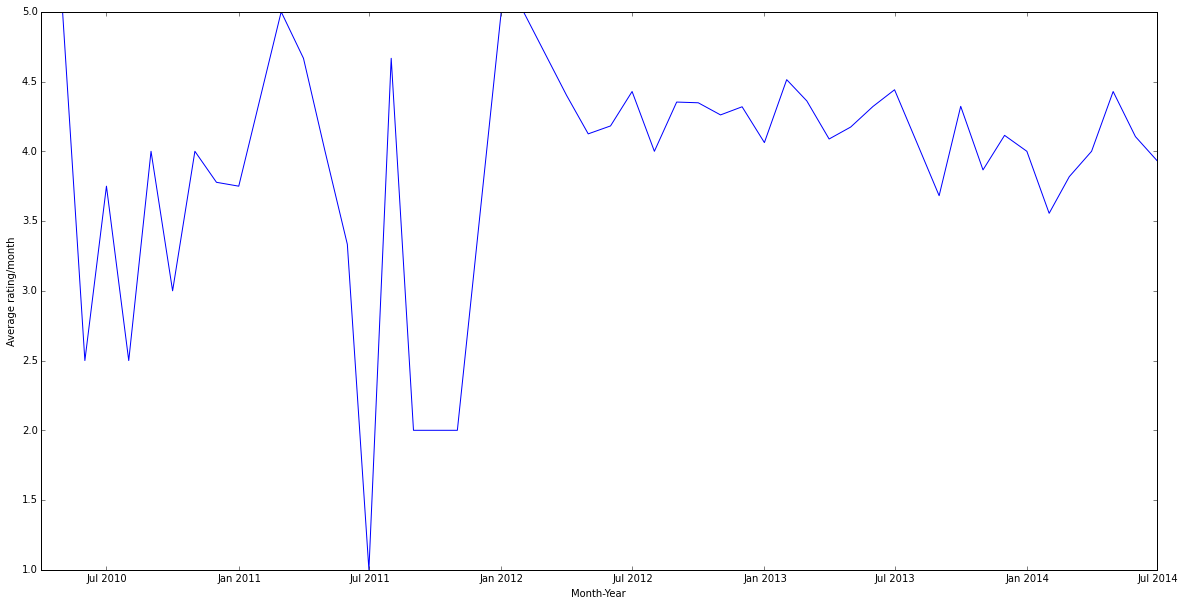

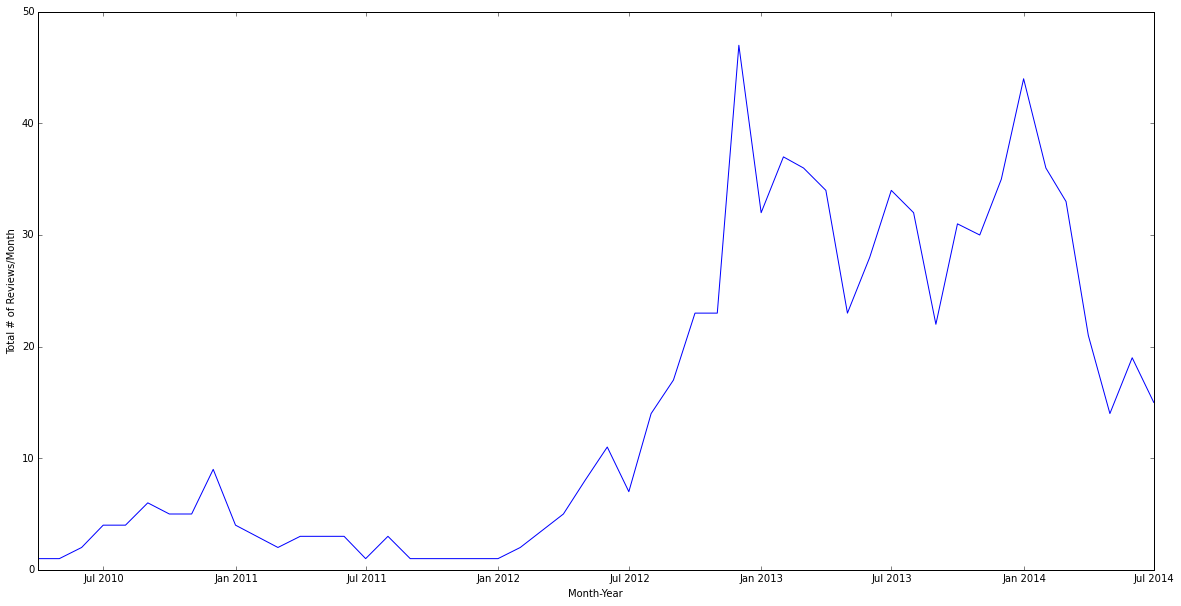

In [85]:
for i,j in enumerate(texts_tri):
    texts.append(texts_uni[i]+texts_bi[i]+ texts_tri[i])

    # remove words that appear only once
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
         for token in text:
             frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
              for text in texts]

dictionary = corpora.Dictionary(text for text in texts)
    # remove stop words and words that appear only once
stop_ids = [dictionary.token2id[stopword] for stopword in stopwords
                if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
dctsavename= './tmp/'+'item'+'_'+product_of_interest_id +'.dct'
dictionary.save(dctsavename)

    #creation of corpus
corpus = [dictionary.doc2bow(text) for text in texts]
corpsavename= './tmp/'+'item'+'_'+product_of_interest_id +'.mm'
corpora.MmCorpus.serialize(corpsavename, corpus)

    #creation of model

model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5)
    #saving lda model
modsavename= './tmp/'+'item'+'_'+product_of_interest_id +'.lda'
model.save(modsavename)
model.show_topics()

plt.figure(figsize=(20,10))
plt.xlabel('Month-Year')
plt.ylabel('Average rating/month')
plt.plot(xvvnew, y)

plt.figure(figsize=(20,10))
plt.xlabel('Month-Year')
plt.ylabel('Total # of Reviews/Month')
plt.plot(xvvnew, y2)




In [86]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      25.268705        1       1  0.033726 -0.038014
2      22.726958        1       2  0.000171  0.014172
3      22.065079        1       3 -0.006802  0.044203
4      17.802541        1       4  0.029742  0.004886
1      12.136717        1       5 -0.056836 -0.025247, topic_info=     Category         Freq                 Term  Total  loglift  logprob
692   Default   362.000000                 work    362  30.0000  30.0000
599   Default   470.000000             wireless    470  29.0000  29.0000
2767  Default   956.000000              samsung    956  28.0000  28.0000
1859  Default   276.000000                smart    276  27.0000  27.0000
382   Default    74.000000                 said     74  26.0000  26.0000
2551  Default   198.000000             smart tv    198  25.0000  25.0000
406   Default   538.000000              adapter    538  24.0000  24.0000
2440  Default   176.000000               device    176  23.0000  23.0000
2211  Default   254.000000                  use    254  22.0000  22.0000
804   Default   384.000000              product    384  21.0000  21.0000
2184  Default   386.000000                great    386  20.0000  20.0000
1597  Default   146.000000                 item    146  19.0000  19.0000
559   Default   132.000000                 plug    132  18.0000  18.0000
1366  Default  1084.000000                   tv   1084  17.0000  17.0000
1766  Default   146.000000                  set    146  16.0000  16.0000
1403  Default   106.000000        bluray player    106  15.0000  15.0000
2366  Default    80.000000     samsung smart tv     80  14.0000  14.0000
1173  Default   140.000000                model    140  13.0000  13.0000
2494  Default   172.000000               bluray    172  12.0000  12.0000
1616  Default   116.000000                 like    116  11.0000  11.0000
1556  Default   218.000000               bought    218  10.0000  10.0000
1656  Default    52.000000            plug play     52   9.0000   9.0000
1527  Default    32.000000                 help     32   8.0000   8.0000
1981  Default    30.000000          doesnt work     30   7.0000   7.0000
196   Default    98.000000                cable     98   6.0000   6.0000
2120  Default    98.000000        samsung smart     98   5.0000   5.0000
2388  Default    70.000000     wireless adapter     70   4.0000   4.0000
2070  Default   134.000000              plugged    134   3.0000   3.0000
1698  Default    72.000000                 play     72   2.0000   2.0000
2610  Default   198.000000           connection    198   1.0000   1.0000
...       ...          ...                  ...    ...      ...      ...
1366   Topic5    96.773047                   tv   1084  -0.3833  -3.9843
804    Topic5    49.178333              product    384  -0.0226  -4.6613
406    Topic5    54.614301              adapter    538  -0.2284  -4.5300
1173   Topic5    23.517908                model    140   0.2844  -5.3634
1220   Topic5     9.959024  wireless connection     32   0.8998  -6.2239
2610   Topic5    29.655533           connection    198   0.1336  -5.1675
2711   Topic5    10.718374              getting     36   0.8411  -6.1648
2494   Topic5    24.956945               bluray    172   0.1312  -5.3107
2421   Topic5    23.361837                  buy    152   0.1852  -5.3803
2256   Topic5    20.138176           samsung tv    112   0.3215  -5.5494
216    Topic5    27.467429              network    200   0.0552  -5.2359
2688   Topic5    18.682420                 home    100   0.3685  -5.6157
456    Topic5    36.100864               player    352  -0.2200  -4.9458
2678   Topic5    46.168292                works    550  -0.4403  -4.7198
502    Topic5    31.848874                 easy    274  -0.1203  -5.0966
196    Topic5    17.589418                cable     98   0.3550  -5.6494
2732   Topic5    14.500854               doesnt     66   0.5416  -5.8582
22

In [88]:
corpus_lda = model[corpus]
for doc in corpus_lda: print doc

[(0, 0.010793879618299633), (1, 0.010804466473621878), (2, 0.010748412559043246), (3, 0.010701113157479007), (4, 0.95695212819155628)]
[(0, 0.95218602086306448), (1, 0.011915277403883914), (2, 0.011959497914899826), (3, 0.011953653061713729), (4, 0.011985550756437965)]
[(1, 0.40124276655592306), (3, 0.5851555272121387)]
[(0, 0.92579951441899844), (1, 0.018631130190518791), (2, 0.018539276320416527), (3, 0.018516719451410743), (4, 0.018513359618655651)]
[(2, 0.12191827465387027), (3, 0.85370909548750373)]
[(0, 0.97596178283997781)]
[(0, 0.96288876920596667)]
[(3, 0.092644374847610594), (4, 0.88619700423378089)]
[(0, 0.92606259971209992), (1, 0.018473941375103765), (2, 0.018416220954947111), (3, 0.018447874657745222), (4, 0.01859936330010388)]
[(0, 0.33042480798207641), (3, 0.65491168165221325)]
[(0, 0.96107264589815244)]
[(0, 0.015658773999989915), (1, 0.015560504003151038), (2, 0.015651180966825277), (3, 0.93743992373021467), (4, 0.015689617299819089)]
[(1, 0.96131911255934555)]
[(0, 0